# Sleep, Exercise, and UCI Life's Effect on a College Student's Health
## Name: Alex Kimm
## Course Project, UC Irvine, Math 10, S24
### ID: 26177943
### **Yes**, I would like to post my notebook on the course's website.

**This project will be based on several statistics that my Fitbit Versa 4 has collected over the a period of over a year, as well as external data that I manually input into a spreadsheet.**

My watch collects several different types of statistics, but this project will focus specifically on data relating to my sleep and exercise. I had to divide the work into separate CSVs to maintain readability and because sleep and exercise data tracked by the watch do not have compatible time logs. Later in the project, I will combine the data later to make more interesting discoveries.

I preemtively load all these libraries here for simplicity, but every time I need to use them, I reload them again for the sake of readability.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from itertools import combinations
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

2024-06-11 21:57:40.529274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The first thing I had to do after importing all the necessary libraries was take inventory of what I had in my dataframe. Firstly, the raw csv file was formatted very peculiarly. Every element was a string, which meant I had to manually (utilizing Ctrl + F) replace every of these entries and replace them with a format that I could actually work with. For example, for working with any numerical data, I would need either ints or floats.

In addition, when Python is compiling CSVs into data, it automatically assumes data in a format that it does not recognize as a string. This would normally be acceptable, but since I have dates and times, it would be advantageous to convert these strings into Python datetime objects.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

# Create a dataframe of sleep data without any missing data.
df_sleep = pd.read_csv('sleep.csv')
df_sleep.dropna(inplace=True)
df_sleep = df_sleep.reset_index(drop=True)

# As mentioned before, I needed to change the dates as datetime objects in Python.
df_sleep['Start Time'] = pd.to_datetime(df_sleep['Start Time'], errors='coerce')
df_sleep['End Time'] = pd.to_datetime(df_sleep['End Time'], errors='coerce')

# It is helpful to not only see when my sleep started and ended, as well as how much that duration was.
df_sleep['Hours Asleep'] = (df_sleep['End Time'].astype(int) - df_sleep['Start Time'].astype(int)).div(10**9).div(3600)
# Must divide by 10e9 because astype returns the datetimes in nanoseconds

It may not look like it, but getting the df_sleep dataframe to accept dates instead of just the default of strings took nearly an hour. The documentation for the python data type datetime was dense and unclear to me, someone who has never worked with that module before. I originally tried using the .apply() function in pandas, but it did not work with datetimes since .apply() works on the entire column of a dataframe and datetimes work with individual strings only.

We now repeat this same process for exercise data.

In [3]:
# Create an dataframe of exercise data.
df_exercise = pd.read_csv("exercise.csv")
df_exercise['Date'] = pd.to_datetime(df_exercise['Date'], errors='coerce')
df_exercise.dropna(inplace=True)

Currently, my sleep and exercise data are separated into two dataframes. I think that there are some very interesting questions to be had about whether certain parts of my exercise affect parts of the type of sleep I get. To find out, I must have to combine the two dataframe into one massive dataframe with over 15 features.

There are, however, a few problems.

1. On some days I wore my watch while I slept but not while I went about my daily activities that day (and vice versa). This means that the time data in my exercise and sleep dataframes are different lengths.

2. The nature of the sleep dataframe is that it keeps track of when I fall asleep and when I wake up, which are two different days...sometimes. This is because, against my doctor's wishes, I frequently sleep after 12 AM **and** my watch keeps track of my naps as well, meaning there are duplicate dates. This necessitates that I find a way to describe how much sleep I get **at night only**.

3. I am given the choice of pairing my exercise with the sleep of the night before or the night after, which fundamentally asks different questions. If I choose to look at exercise and the same night's sleep, then my data is framed to answer "How do my exercise habits affect my sleep?", whereas looking at the previous night's sleep and the activity the next day asks "How does my sleep affect my exercise?". I personally think that looking at how my sleep is affected by the day's exercise will be more interesting insight.

4. If I want to combine my data, I need to manipulate both dataframes because sleep datetimes are given with precision to the second, while exercise datetimes are given with precision to the day.

I will be resolving all of the issues in the following code blocks.

In [4]:
# Create a new column that keeps track of which day my sleep belongs (problem 2).
df_sleep['Date'] = df_sleep['Start Time']

# If I sleep and wake up on the same day, then that counts as the previous day's sleep.
# Otherwise, it is safe to say that it is the same day.
for i in range(0, len(df_sleep)):
    if df_sleep['Start Time'][i].date() == df_sleep['End Time'][i].date():
        df_sleep.loc[i,'Date'] = df_sleep['Start Time'][i].date() - timedelta(days = 1)
    else:
        df_sleep.loc[i, 'Date'] = df_sleep['Start Time'][i].date()

# Ensure that the entire column is not changed to the general dataframe "object" and instead "datetime".
df_sleep = df_sleep.astype({"Date": "datetime64[ns]"})

/var/folders/fw/7zvj6rks73qb1bvpcbz39q6c0000gn/T/ipykernel_5223/3482543601.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-05-29' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_sleep.loc[i,'Date'] = df_sleep['Start Time'][i].date() - timedelta(days = 1)


However, on days where I both take a nap during the day, there is a chance that that day is rolled back to the previous day. However, this is not an issue for reasons that will be addressed in a subsequent code block.

In [5]:
# Create a new set of columns to add matching dates from the exercise and sleep dataframes.
df_exercise_features = ["Calories Burned", "Steps", "Distance", "Floors", "Minutes Sedentary",
                        "Minutes Lightly Active", "Minutes Fairly Active", "Minutes Very Active",
                        "Activity Calories"]

# Make a new dataframe out of those columns.
df_exercise_2 = pd.DataFrame(np.zeros((0,len(df_exercise_features))), columns=df_exercise_features)

# Filter for the same date, then add them to the new exercise dataframe.
for i in range(1, len(df_sleep)):
    for j in range(1, len(df_exercise)):
        if df_sleep['Date'][i] == df_exercise['Date'][j]:
            df_exercise_2 = df_exercise_2._append(df_exercise.iloc[j], ignore_index=True)

Now repeat a similar process for the sleep dataframe to remove excessive data in the form of naps. This is done by taking advantage of the fact that sleep.csv lists days in reverse chronological order. Thus, any groups of sleep that occur on the same day will have the first occurrence (which will take place later, at night) be chosen.

In [6]:
df_sleep_features = ['Start Time','End Time','Minutes Asleep','Minutes Awake','Number of Awakenings','Time in Bed',
                  'Minutes REM Sleep','Minutes Light Sleep','Minutes Deep Sleep','Hours Asleep','Date']

df_sleep_2 = pd.DataFrame(np.zeros((0,len(df_sleep_features))), columns=df_sleep_features)

for i in range(1, len(df_sleep)):
    if df_sleep['Date'][i] == df_sleep['Date'][i-1]:
        continue
    else:
        df_sleep_2 = df_sleep_2._append(df_sleep.iloc[i-1], ignore_index=True)

# Remove start and end time because they are irrelevant for the time being.
df_sleep_2.drop(columns=['Start Time', 'End Time'], axis=1)

/var/folders/fw/7zvj6rks73qb1bvpcbz39q6c0000gn/T/ipykernel_5223/2331035335.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sleep_2 = df_sleep_2._append(df_sleep.iloc[i-1], ignore_index=True)


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Hours Asleep,Date
0,360.0,73.0,37.0,433.0,58.0,270.0,32.0,7.233333,2024-05-29
1,296.0,42.0,29.0,338.0,36.0,183.0,77.0,5.650000,2024-05-28
2,370.0,72.0,37.0,442.0,61.0,262.0,47.0,7.366667,2024-05-27
3,403.0,89.0,41.0,492.0,74.0,285.0,44.0,8.200000,2024-05-24
4,185.0,26.0,18.0,211.0,34.0,121.0,30.0,3.533333,2024-05-23
...,...,...,...,...,...,...,...,...,...
329,322.0,46.0,37.0,368.0,87.0,184.0,51.0,6.150000,2023-03-14
330,426.0,60.0,53.0,486.0,118.0,227.0,81.0,8.100000,2023-03-13
331,241.0,44.0,26.0,285.0,53.0,131.0,57.0,4.750000,2023-03-12
332,453.0,77.0,46.0,530.0,81.0,293.0,79.0,9.833333,2023-03-11


Now, we can use our previously collected dataframes containing exercise and sleep data and now combine them into one big dataframe! When we eventually combine the exercise and sleep dataframes, it is important that there isn't a duplicate date column because that will cause issues when we try to work with that data.

In [7]:
sleep_cols = ['Hours Asleep', 'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings', 
           'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Deep Sleep']
df_sleep_3 = df_sleep_2[sleep_cols]

# Create the dataframe that will house both dataframes' original data.
col=['Date', 'Hours Asleep', 'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
     'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Deep Sleep', 'Calories Burned',
     'Steps', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active',
     'Minutes Very Active', 'Activity Calories']
df = pd.DataFrame(np.zeros((0,len(col))), columns=col)

# If a date is shared between exercise and sleep, then they are added to the new dataframe.
for i in range(len(df_sleep_2)):
    for j in range(len(df_exercise_2)):
        if df_sleep_2['Date'][i] == df_exercise_2['Date'][j]:
            a = pd.concat([df_sleep_3.iloc[i], df_exercise_2.iloc[j]])
            df = df._append(a, ignore_index=True)

/var/folders/fw/7zvj6rks73qb1bvpcbz39q6c0000gn/T/ipykernel_5223/3050805482.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(a, ignore_index=True)


Now, we can finally analyze data among both sleep and exercise data. The first course of action is to create a correlation plot to get a good idea of which variables are most correlated with others. 

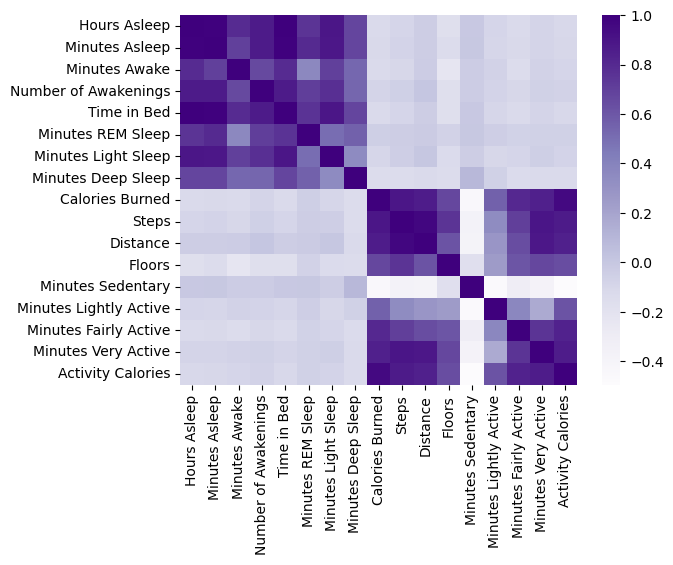

In [8]:
import seaborn as sns

df_columns = ['Hours Asleep', 'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
              'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Deep Sleep', 'Calories Burned',
              'Steps', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active',
              'Minutes Very Active', 'Activity Calories']

corr = df[df_columns].corr()
obj = sns.heatmap(data=corr, cmap='Purples');

Just visually, it appears that generally the sleep variables have almost no correlation with exercise variables. I am extremely disappointed that there is no deep link. With that said, there is still a wealth of knowledge to be had about how aspects of my exercise relates to itself, as well as how aspects of my sleep relates to itself.

Let's focus on just sleep for now. Looking at the heatmap, it appears that there is a moderate correlation between the minutes of REM, Light, and Deep Sleep that I get and the Number of Awakenings in one night. However, what if there is some combination of these features that altogether better predict how well I sleep? Firstly, we'll have to see if I at all meet the benchmark. According to <a href='https://www.healthline.com/health/how-much-deep-sleep-do-you-need#stages-of-sleep'>Healthline</a>, the average person should aim to get around 25% REM, 45% Light, 25% Deep Sleep, and 5% Awake/Restless/Very Light. First, let's observe if this is indeed the case for my sleep.

The mean proportion of REM Sleep is 0.19654752855714724
The mean proportion of Light Sleep is 0.6227084642542776
The mean proportion of Deep Sleep is 0.18074400718857522
The mean proportion of Restlessness is 0.17755921760334448


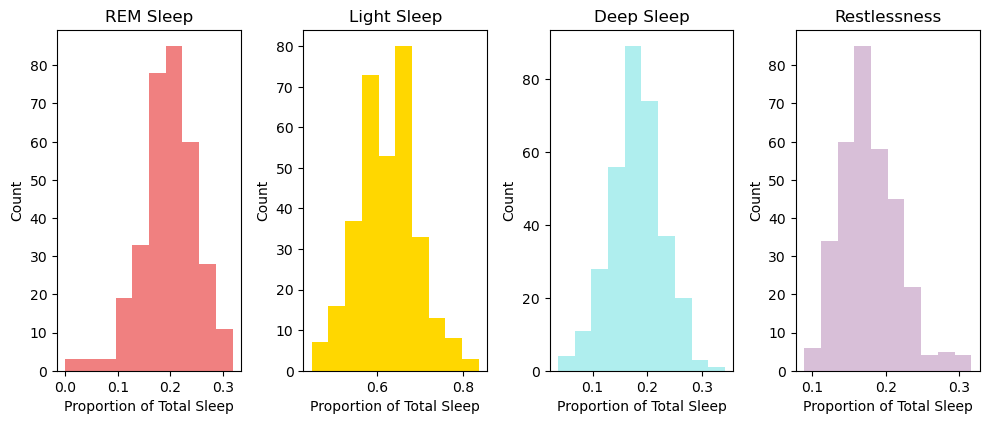

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_size_inches(10,4,forward=True)

fig.tight_layout()

ax1.hist(df['Minutes REM Sleep'] / df['Minutes Asleep'], color='lightcoral');
ax1.set_title("REM Sleep")
ax1.set_xlabel("Proportion of Total Sleep")
ax1.set_ylabel("Count")

ax2.hist(df['Minutes Light Sleep'] / df['Minutes Asleep'], color='gold');
ax2.set_title("Light Sleep")
ax2.set_xlabel("Proportion of Total Sleep")
ax2.set_ylabel("Count")

ax3.hist(df['Minutes Deep Sleep'] / df['Minutes Asleep'], color='paleturquoise');
ax3.set_title("Deep Sleep")
ax3.set_xlabel("Proportion of Total Sleep")
ax3.set_ylabel("Count")

ax4.hist(df['Minutes Awake'] / df['Minutes Asleep'], color='thistle');
ax4.set_title("Restlessness")
ax4.set_xlabel("Proportion of Total Sleep")
ax4.set_ylabel("Count")

print(f"The mean proportion of REM Sleep is {(df['Minutes REM Sleep'] / df['Minutes Asleep']).mean()}")
print(f"The mean proportion of Light Sleep is {(df['Minutes Light Sleep'] / df['Minutes Asleep']).mean()}")
print(f"The mean proportion of Deep Sleep is {(df['Minutes Deep Sleep'] / df['Minutes Asleep']).mean()}")
print(f"The mean proportion of Restlessness is {(df['Minutes Awake'] / df['Minutes Asleep']).mean()}")

Unfortunately, it seems that I in fact do not get the proper amount of each sleep. Particularly, I am getting too much Light Sleep and Restlessness and too little of both REM and Deep Sleep. This suggests that it takes a while for me to fall asleep, as well as the quality of the sleep that I do get tends to be lower than what I can possibly achieve. This is detrimental to long-term health because REM and Deep Sleep are crucial to the replenishment of cells from the previous day. Essentially, Deep Sleep allows for the body to do its daily cleanup.

Let's see how well each of these four features affect how many times I wake up during the night.

In [10]:
from itertools import combinations
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

features = ['Minutes Awake', 'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Deep Sleep']
combos = []

for i in range(1,len(df_columns)):
    combos += combinations(features, i)
combos = [list(combo) for combo in combos]

train_list = []
test_list = []

def predict_calories():
    for combo in combos:
        lm = LinearRegression()

        x_train, x_test, y_train, y_test = train_test_split(df[combo], df['Number of Awakenings'], test_size=0.5, random_state=0)

        lm.fit(x_train, y_train)

        train_list.append(lm.score(x_train, y_train))
        test_list.append(lm.score(x_test, y_test))

predict_calories()

print(f"The best combination of features is {combos[test_list.index(np.max(test_list))]}, with a score of {np.max(test_list)}")

The best combination of features is ['Minutes Awake', 'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Deep Sleep'], with a score of 0.7694802190869687


Thus, we conclude the best subset of features to use to predict how many times I wake up per night is the subset that contains all of the Minutes of the Type of Sleep that I get per night. This makes sense, since the number of awakenings should roughly translate to a combined look at how all of my sleep interacts with each other. However, what if a linear model is not the best model for this function? It's equally possible that there is some more complex polynomial that will match these results better, so let's explore those possibilities.

We will be using Ridge Regression and Lasso Regression. We must first normalize this data because the penalties for both Ridge and Lasso Regression depend on the magnitude of the coefficients. Larger coefficients from larger data will have greater effects, so we want to minimize this. As a baseline, let's compare it with a normal Linear Regression model. Note: Linear Model's performance does not depend on scaling, but we can still use scaled data to receive the same results regarding performance.

In [11]:
alpha = 0.01
features = ["Minutes Awake", "Minutes REM Sleep", "Minutes Light Sleep", "Minutes Deep Sleep", "Number of Awakenings"]

df_scaled = df[features]

for i in features:
    col = (df[i] - df[i].mean()) / df[i].std()
    df_scaled.loc[:,i] = col

# Linear Regression (X - X')/std(X)
lm = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=1)
lm_scores = cross_val_score(lm, df[features[0:4]], df[features[4]], cv=kf, scoring='r2')

for i in range(len(lm_scores)):
    print(f"Fold {i+1} R^2 score: {lm_scores[i]}")

print()

# Ridge Regression (X - X')/std(X)
ridge = Ridge(alpha=alpha)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
ridge_scores = cross_val_score(ridge, df[features[0:4]], df[features[4]], cv=kf, scoring='r2')

for i in range(len(ridge_scores)):
    print(f"Fold {i+1} R^2 score: {ridge_scores[i]}")

print()

# Lasso Regression (X - X')/std(X)
lasso = Lasso(alpha=alpha)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
lasso_scores = cross_val_score(lasso, df[features[0:4]], df[features[4]], cv=kf, scoring='r2')
for i in range(len(lasso_scores)):
    print(f"Fold {i+1} R^2 score: {lasso_scores[i]}")
print()

print(f"The mean R^2 value for this Linear Model is: {lm_scores.mean()}.")
print(f"The mean R^2 value for this Ridge Model is: {ridge_scores.mean()}.")
print(f"The mean R^2 value for this Lasso Model is: {lasso_scores.mean()}.")

Fold 1 R^2 score: 0.7715045370093095
Fold 2 R^2 score: 0.7552979419475101
Fold 3 R^2 score: 0.74803283059773
Fold 4 R^2 score: 0.6948217051159891
Fold 5 R^2 score: 0.7907530964553503

Fold 1 R^2 score: 0.7715045352923458
Fold 2 R^2 score: 0.7552979416026261
Fold 3 R^2 score: 0.7480328363765334
Fold 4 R^2 score: 0.6948217024395231
Fold 5 R^2 score: 0.7907530976467543

Fold 1 R^2 score: 0.7714936422629195
Fold 2 R^2 score: 0.7552997471034357
Fold 3 R^2 score: 0.7480446134512566
Fold 4 R^2 score: 0.6948235317103824
Fold 5 R^2 score: 0.7907538024471161

The mean R^2 value for this Linear Model is: 0.7520820222251777.
The mean R^2 value for this Ridge Model is: 0.7520820226715565.
The mean R^2 value for this Lasso Model is: 0.7520830673950221.


We use Ridge and Lasso Regression to avoid overfitting of data, but as it turns out, the Linear Model has similar performance to the other two models.

Obviously, since this data is fourth-dimensional, there really is no good way of representing it in two dimensions without greatly simplifying the information we wish to convey. However, we can create 2-dimensional plots of each combination of data.

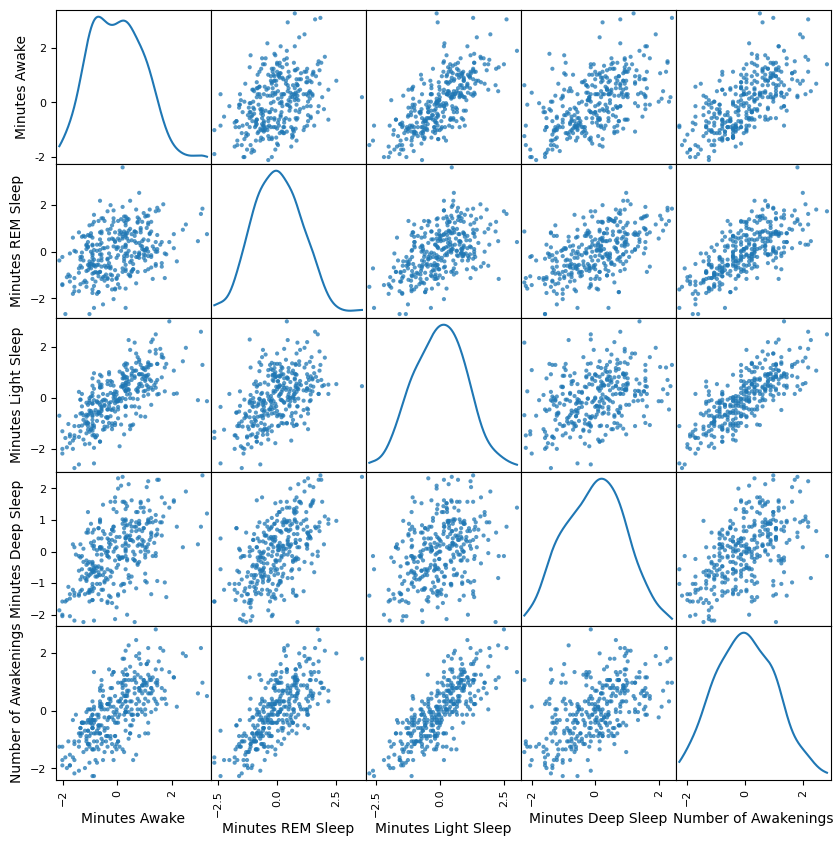

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_scaled, alpha=0.75, figsize=(10, 10), diagonal='kde');

We only really care about the final row, as it shows each combination of the comparisons of each feature against the feature we set out to show, the Number of Awakenings. We can clearly see that for all of them, there is at least a weak to moderate correlation, particular with REM Sleep and Light Sleep.

I have one last CSV file to load into this data science project! However, first, I must start with a short explanation. UCI is known for many things, but perhaps the strangest is a tradition relating to what people call "Petr stickers", which are stickers drawn as parodies of UCI's mascot, Peter the Anteater. It is not uncommon to see students run to a certain part of campus from Aldrich after finding out where on campus these stickers are being released.

I have participated in a few of these runs and have kept track of on which days I have collected stickers. Clearly, the physical aspect of running in order to obtain these stickers contributes to my physical exercise of that day, at least in part. I want to use the remainder of this project to see if we can classify days where I do these runs and days where I do not based on my watch's exercise data.

In [13]:
# Create a new dataframe that has all data with a new "Sticker Received" column for that day.
df['Sticker Received'] = np.full(len(df),False)

df_petr = pd.read_csv("petr.csv")
df_petr = df_petr.drop(labels=['Name', 'Trade Date', 'Traded For', 'Petr', 'Notes', 'Unnamed: 6'],axis=1)
df_petr['Collection Date'] = pd.to_datetime(df_petr['Collection Date'], errors='coerce')

unique_dates = np.unique(df_petr['Collection Date'])
df_petr_2 = pd.DataFrame(np.zeros((0,1)), columns=['Collection Date'])
df_petr_2['Collection Date'] = unique_dates
df_petr_2['Collection Date'] = pd.to_datetime(df_petr_2['Collection Date'], errors='coerce')

for i in range(len(df)):
    for j in range(len(df_petr_2)):
        if df['Date'][i] == df_petr_2['Collection Date'][j]:
            df.loc[i, 'Sticker Received'] = True
            break

We can perform logistic regression to classify this data into binary classes, 0: "I did not run for stickers this day", and 1: "I did run for stickers this day". 

The R^2 value of this Logistic Regression model is: 0.8575851393188855.



/var/folders/fw/7zvj6rks73qb1bvpcbz39q6c0000gn/T/ipykernel_5223/2472311830.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_petr["Sticker Received"] = df_petr["Sticker Received"].astype(int)


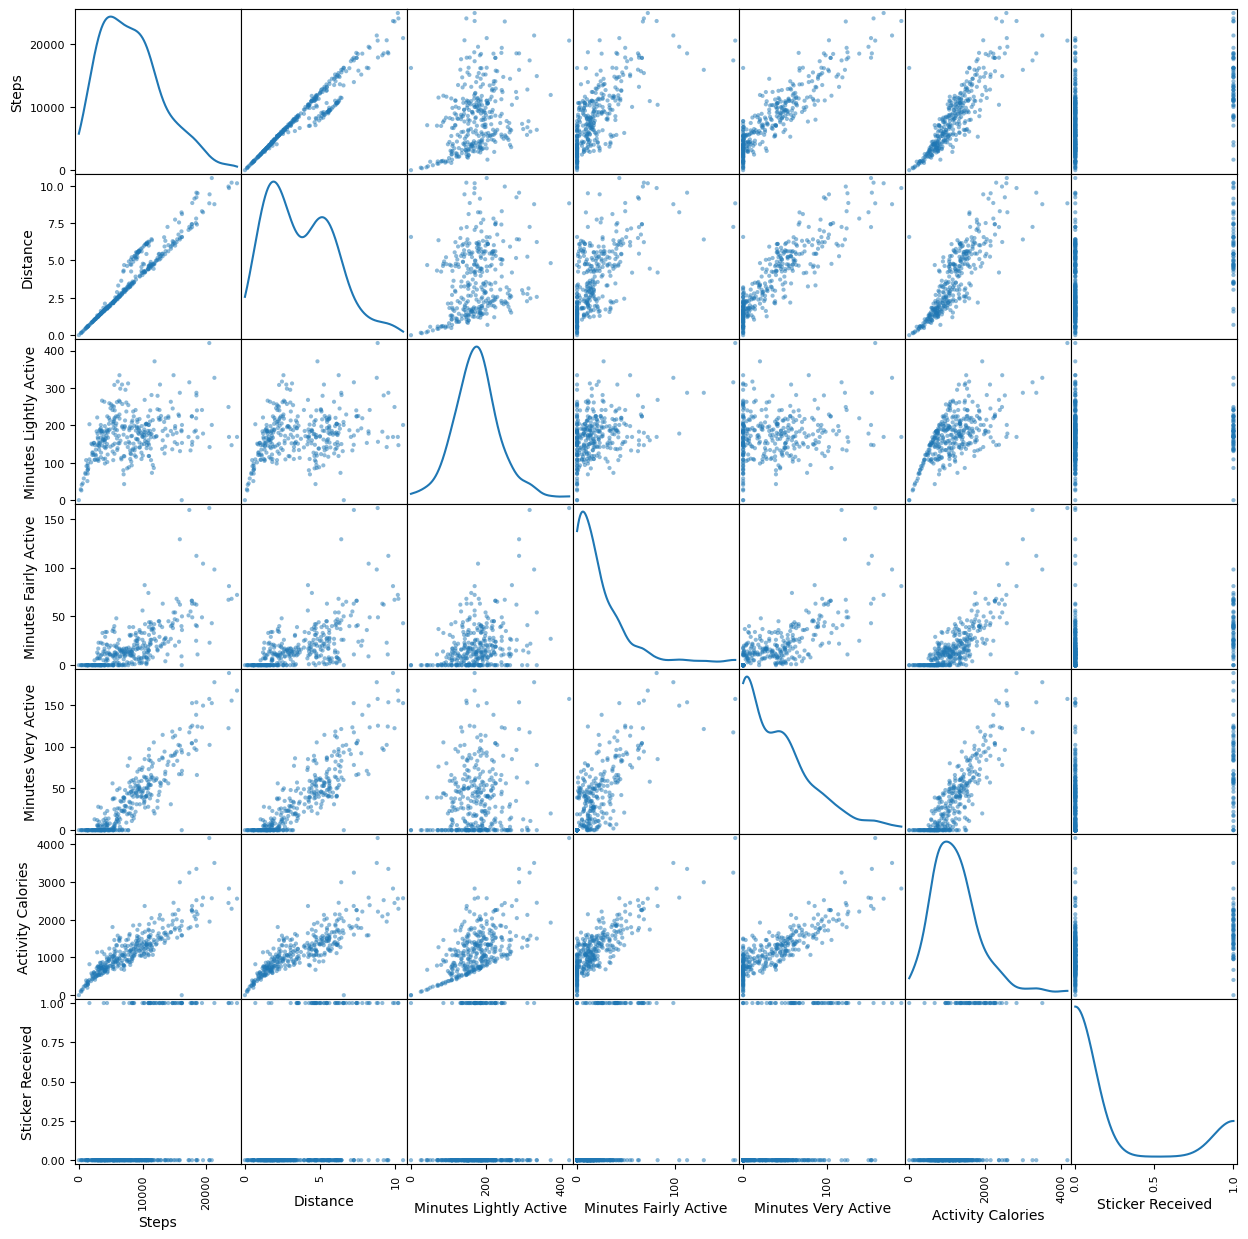

In [14]:
features = ["Steps", "Distance", "Minutes Lightly Active", "Minutes Fairly Active",
            "Minutes Very Active", "Activity Calories", "Sticker Received"]

log_model = LogisticRegression(max_iter=10000)
log_model.fit(np.array(df[features[0:6]]), np.array(df[features[6]]));

log_score = log_model.score(np.array(df[features[0:6]]), np.array(df[features[6]]))
print(f"The R^2 value of this Logistic Regression model is: {log_score}.\n")

df_petr = df[features]
df_petr["Sticker Received"] = df_petr["Sticker Received"].astype(int)

scatter_matrix(df_petr, alpha=0.5, figsize=(15, 15), diagonal='kde');

When I was using Linear Regression, it was very easy to tell whether there was a correlation between two different numerical data types, but now that we're using binary classification, the results are much more nebulous. To remedy this, we can instead plot using logistic regression.

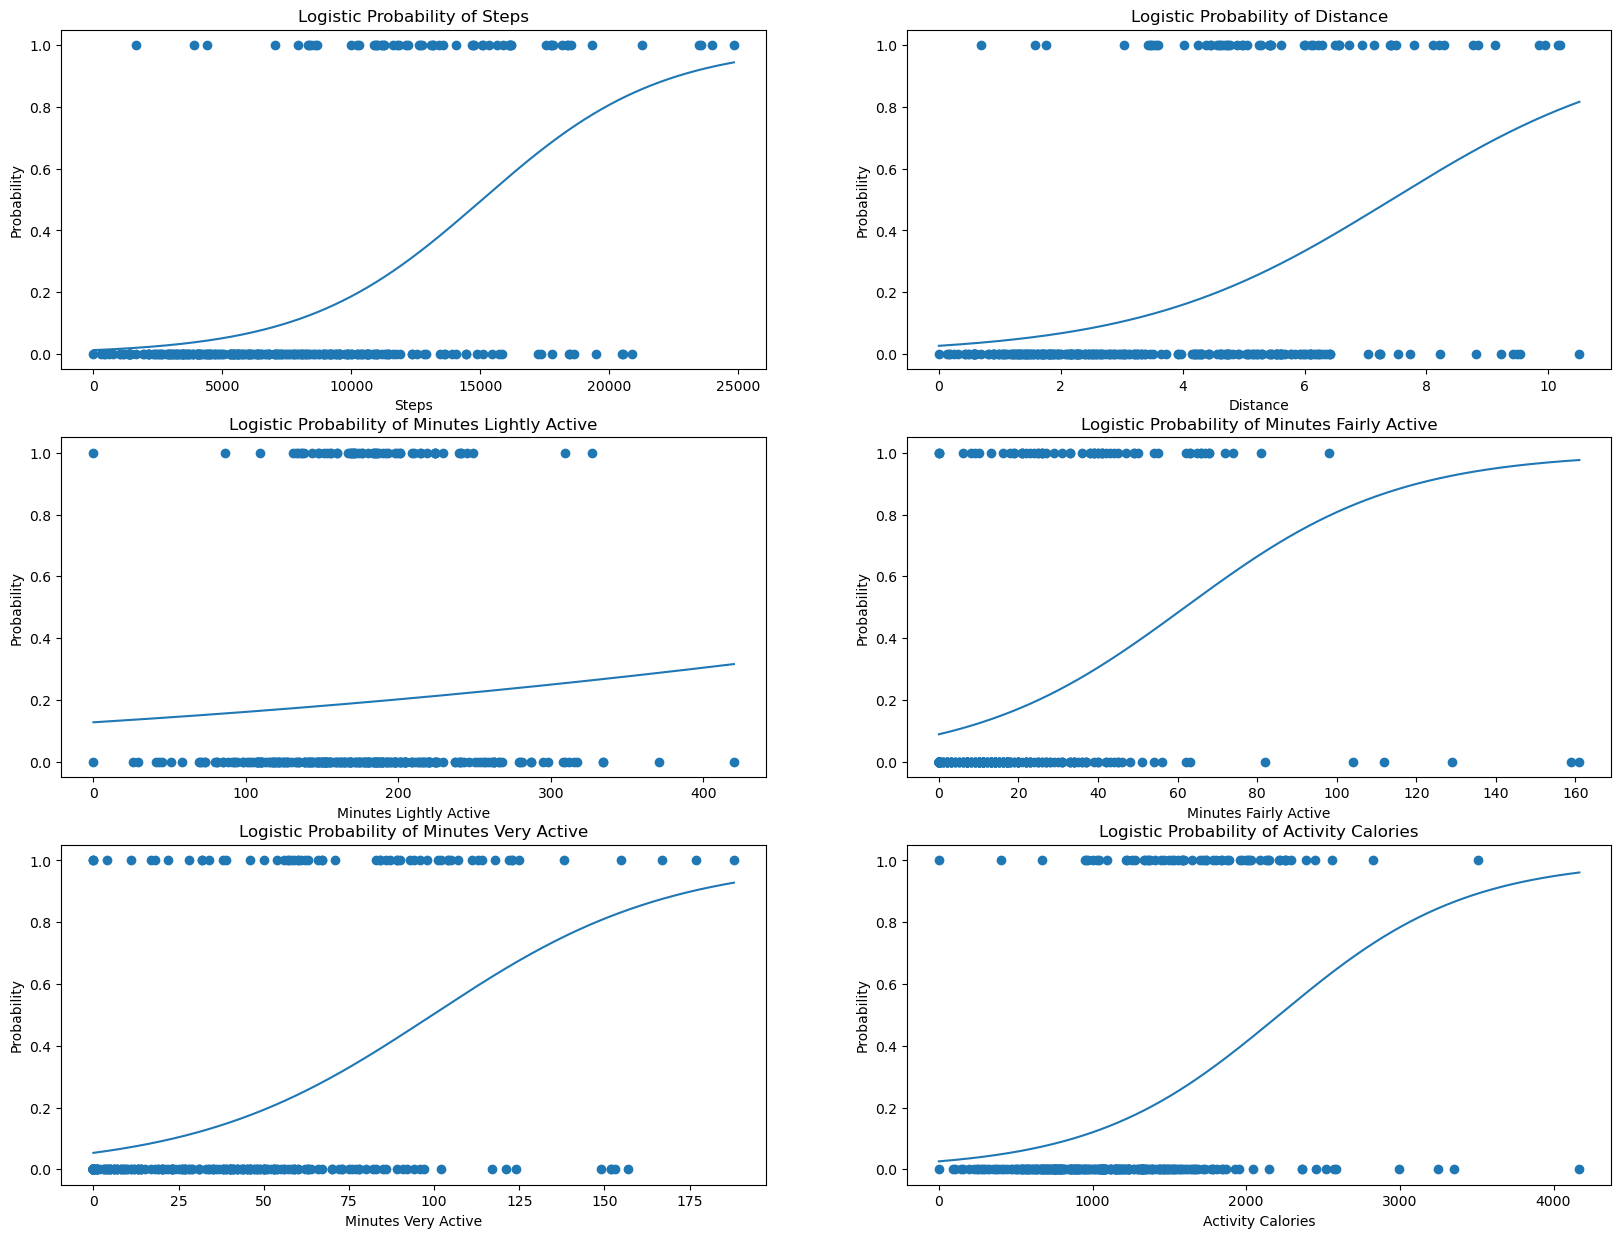

In [15]:
features = ["Steps", "Distance", "Minutes Lightly Active", "Minutes Fairly Active",
            "Minutes Very Active", "Activity Calories"]

fig, axes = plt.subplots(3,2,figsize=(20,15))
axes = axes.ravel()

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

for i in range(len(features)):
    X = np.linspace(df_petr[features[i]].min(), df_petr[features[i]].max(), num=1000)

    log_model = LogisticRegression()
    log_model.fit(np.array(df_petr[features[i]]).reshape(-1,1), np.array(df_petr["Sticker Received"]))
    logistic_prob = sigmoid(log_model.coef_ * X + log_model.intercept_)
    
    axes[i].plot(X.reshape(-1,1), logistic_prob.reshape(-1,1))
    axes[i].set_title(f"Logistic Probability of {features[i]}")
    axes[i].set_xlabel(f"{features[i]}")
    axes[i].set_ylabel("Probability")

    axes[i].scatter(np.array(df_petr[features[i]]), np.array(df_petr["Sticker Received"]))

This is much more clear which features correspond to which class: 1, being stickers received, and 0, no sticker received that day. However, as we learned earlier, this model has an R^2 value of roughly 0.85, which is not very clear by breaking it down into individual plots. Clearly, the combination of all of these features make a better model than alone.

To better try and visualize this data, we can use Principal Component Analysis.

Text(0.5, 1.0, 'Data After Principal Component Analysis')

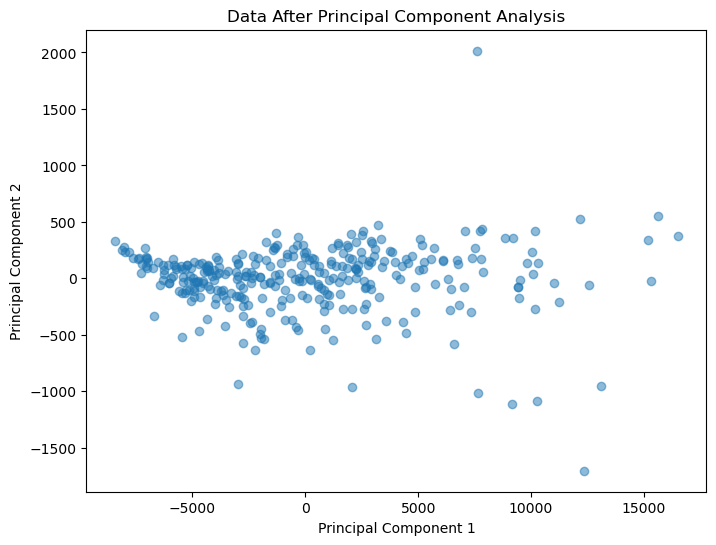

In [16]:
from sklearn.decomposition import PCA

features = ["Steps", "Distance", "Minutes Lightly Active", "Minutes Fairly Active",
            "Minutes Very Active", "Activity Calories", "Sticker Received"]

fig, ax = plt.subplots(figsize=(8,6))

# We can apply PCA to work on this multi-dimensional model.
pca = PCA(n_components=2)
pca.fit(df_petr)
transformed_data = pca.transform(df_petr)

# Let's visualize the principle components
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5);

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Data After Principal Component Analysis")

As we can see, our data has been reduced from an incomprehensible 6 dimensions down to just two.

This next section will focus on neural networks, particularly by using the tensorflow library. To be 100% transparent, since I am unfamiliar with the library, I used a few YouTube tutorials to help get started, as well as much of tensorflow's native documentation. <a href='https://youtu.be/6_2hzRopPbQ?feature=shared'>This</a> is one tutorial that I used. However, to prove that I do have some level of understanding of what is being done in the process, I will be annotating what each major step does along the way.

I will be trying to create a model that will be able to accurately predict whether or not the sleep and exercise I received that day is enough to tell if I ran for a sticker that day.

In [17]:
# Reimport tensorflow
import tensorflow as tf

In [18]:
# I am going to be reusing the df library, minus the Date column
df

,Date,Hours Asleep,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Sticker Received
0,2024-05-28,5.650000,296.0,42.0,29.0,338.0,36.0,183.0,77.0,3131.0,14451.0,5.78,37.0,684.0,185.0,40.0,89.0,1671.0,False
1,2024-05-27,7.366667,370.0,72.0,37.0,442.0,61.0,262.0,47.0,2375.0,6989.0,4.25,0.0,1320.0,80.0,1.0,39.0,803.0,False
2,2024-05-24,8.200000,403.0,89.0,41.0,492.0,74.0,285.0,44.0,2878.0,12209.0,4.99,28.0,977.0,171.0,19.0,62.0,1363.0,True
3,2024-05-23,3.533333,185.0,26.0,18.0,211.0,34.0,121.0,30.0,3603.0,15120.0,5.99,23.0,812.0,198.0,54.0,113.0,2145.0,True
4,2024-05-22,4.383333,226.0,37.0,27.0,263.0,47.0,144.0,35.0,2799.0,11740.0,4.44,22.0,867.0,188.0,37.0,23.0,1199.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,2023-03-14,6.150000,322.0,46.0,37.0,368.0,87.0,184.0,51.0,2969.0,5574.0,2.27,9.0,623.0,308.0,20.0,3.0,1463.0,False
319,2023-03-13,8.100000,426.0,60.0,53.0,486.0,118.0,227.0,81.0,2527.0,5361.0,2.15,9.0,852.0,204.0,0.0,0.0,883.0,False
320,2023-03-12,4.750000,241.0,44.0,26.0,285.0,53.0,131.0,57.0,3004.0,6500.0,2.79,10.0,584.0,298.0,15.0,13.0,1524.0,False
321,2023-03-11,9.833333,453.0,77.0,46.0,530.0,81.0,293.0,79.0,2720.0,5569.0,2.28,8.0,618.0,216.0,40.0,7.0,1231.0,False


In [19]:
# Remove independent variables from the data that we are trying to predict
# That is, X includes everything except date and whether I received a sticker that day.
X = df.drop(['Date', 'Sticker Received'], axis=1)
y = df['Sticker Received'].apply(lambda x: 1 if x==True else 0)

# Create a train test split of data to later test the accuracy of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

View the training data we have collected.

In [20]:
X_train.head()

,Hours Asleep,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
235,8.650000,433.0,86.0,51.0,519.0,40.0,332.0,61.0,2706.0,10641.0,6.09,0.0,793.0,139.0,3.0,50.0,1115.0
159,8.933333,455.0,80.0,50.0,535.0,115.0,260.0,80.0,3857.0,18460.0,9.22,25.0,571.0,280.0,62.0,96.0,2520.0
106,7.116667,376.0,51.0,33.0,427.0,85.0,206.0,85.0,3532.0,18152.0,9.13,23.0,835.0,183.0,63.0,98.0,2090.0
274,8.383333,435.0,68.0,44.0,503.0,88.0,286.0,61.0,1750.0,395.0,0.16,1.0,1016.0,26.0,0.0,0.0,91.0
57,8.900000,415.0,59.0,47.0,474.0,86.0,250.0,79.0,2927.0,8209.0,4.26,8.0,719.0,171.0,14.0,46.0,1325.0


In [21]:
y_train.head()

235    0
159    0
106    1
274    0
57     0
Name: Sticker Received, dtype: int64

In [22]:
# Sequential will be our primary model class, where each layer has one input and one output.
from tensorflow.keras.models import Sequential
# Dense is a layer without our network, which allows us to create several layers.
from tensorflow.keras.layers import Dense
# Our metric to see how successful our model is
from sklearn.metrics import accuracy_score

I had to learn a bit about sigmoid in relation to ReLU, and it turns out ReLU is used here because it is <a href=https://wandb.ai/ayush-thakur/dl-question-bank/reports/ReLU-vs-Sigmoid-Function-in-Deep-Neural-Networks--VmlldzoyMDk0MzI>much easier to compute</a>. For models that decide 0 or 1, simplicity is necessary when there is a requirement of a lot of computing power (and for deep learning models like this one, that is indeed the case). Therefore, for the hidden layers, we use ReLU.

In [23]:
model = Sequential()
# Dense layers with each layer having 32, 64, and 1 nodes, respectively.
# Relu doesn't take raw data out, it takes a minimum of zero and maximum of one, similar to sigmoid.
# Our input data is the same number of dimensions as our dataframe.
model.add(Dense(units=32, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=64, activation='relu'))
# This is what we're trying to predict, so that's why there is only one node.
model.add(Dense(units=1, activation='sigmoid'))

/Users/alexkimm/anaconda3/envs/math9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compiling our model tells the model what loss we're using, and how it wants to measure success.
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# BCE is a measure of error, optimizer is an option of how we find that error (and reduce it), and accuracy is clear.

In [25]:
# Iterate our model with 250 times, with 32 points each time.
model.fit(X_train, y_train, epochs=250, batch_size=32)

Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4787 - loss: 5284039.0000
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8110 - loss: 0.6841 
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8019 - loss: 0.6746 
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7537 - loss: 0.6698 
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7717 - loss: 0.6617 
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7977 - loss: 0.6503 
Epoch 7/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7877 - loss: 0.6458 
Epoch 8/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8139 - loss: 0.6347 
Epoch 9/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.6315 
Epoch 10/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.6201 
Epoch 11/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7793 - loss: 0.6254 
Epoch 12/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8054

In [26]:
y_predicted = model.predict(X_test)
y_predicted = [0 if val < 0.5 else 1 for val in y_predicted]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


I will say that I ran this y_predicted many times and each time it cmae out as an array of just zeros, which suggests that the model ends up thinking that a sticker is not collected on most days, which makes sense. This may be due to the fact that the number of days where stickers were collected is around 90 and the total number of days in this entire dataset is more than 300, meaning it is vanishingly unlikely that I collected a sticker that day. Even so, this uniform guess of zeros might be something I look into in the future.

In [27]:
np.array(y_predicted)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
accuracy_score(y_test, y_predicted)

0.8615384615384616

Thus, this model turns out to be relatively accurate, being able to correctly guess if I ran for stickers 86% of the time.

Thus, we have come to a conclusion with several interesting discoveries. Firstly, at least for my own sleep, there does not seem to be a significant correlation between the amount of sleep and exercise that I receive. In the heatmap that we looked at above, there was at best a very weak positive correlation.

Then, we looked at my sleep and exercise individually. When it comes to sleep, the best way to predict how many times I am awaken at night, the best determiner out of how many minutes restless, REM, Light, and Deep sleep, turns out to be a combination of all of these different features, with a model that had a R^2 score of about 0.76.

For exercise, I performed logistic regression to predict a new variable that I put into binary classes, whether I ran for a sticker that day or not. It turns out, the model had an R^2 value of about 0.85, meaning the model fit quite well.

Finally, we performed a neural network with two layers with all of the variables (minus the date) to test if these variables could altogether predict whether I ran for a sticker that day. The network was very good, receiving similar results to the R^2 score of the logistic model, with an accuracy of 86%.

For future projects, I think it might be better to run the neural network with more layers or greater epochs. I used 2 layers and 250 generations because my computer began to run more slowly if I increased any of these values.

Thank you for reading this project.